### import libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN



### Load Preprocessed Data

In [39]:
df = pd.read_csv("data/processed_data.csv", header=None)

df.columns = [
    'gender', 'age_bin', 'hypertension', 'heart_disease',
    'ever_married', 'work_type', 'Residence_type',
    'avg_glucose_level_std', 'bmi_bin', 'smoking_status', 'stroke'
]

print("✅ Data loaded successfully!")
print("Shape:", df.shape)
df.head()


✅ Data loaded successfully!
Shape: (5111, 11)


,gender,age_bin,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level_std,bmi_bin,smoking_status,stroke
0,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Male,6.0,0,1,Yes,Private,Urban,2.7063754415827868,1.0,formerly smoked,1
2,Female,5.0,0,0,Yes,Self-employed,Rural,2.1215585391500795,1.0,never smoked,1
3,Male,7.0,0,1,Yes,Private,Rural,-0.005028301304808307,1.0,never smoked,1
4,Female,4.0,0,0,Yes,Private,Urban,1.4373580996725381,1.0,smokes,1


## Graphical Approach - Boxplot (IQR)

### Boxplot(IQR)

Processing data and detecting outliers on columns: ['age', 'avg_glucose_level', 'bmi']

IQR Outlier Removal Summary:
  Original rows: 5110
  Rows after sequential IQR removal: 4476
  Total outliers removed: 634

Cleaned DataFrame saved to: processed_data_outliers_removed.csv


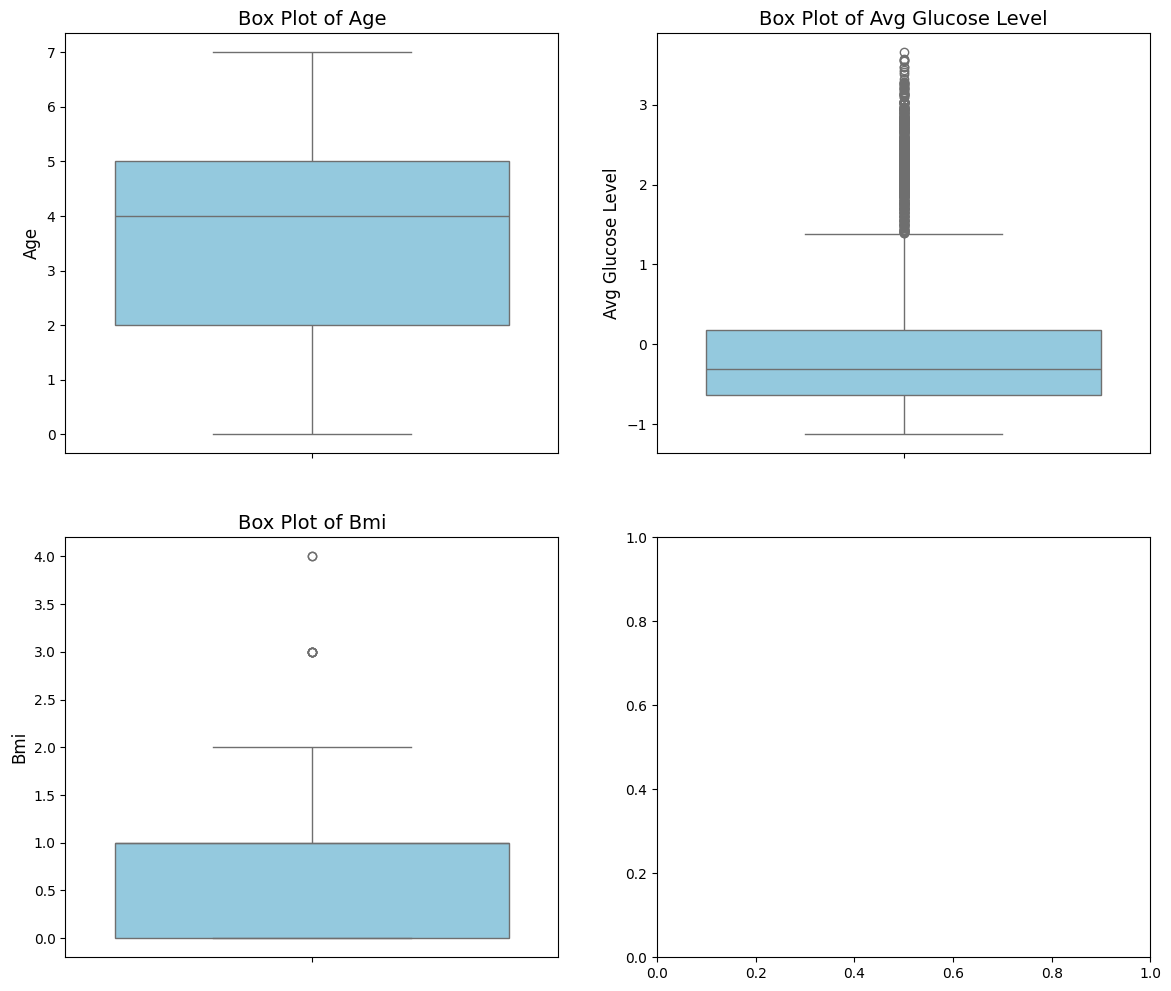

In [40]:

# --- 1. Load Data ---
file_name = 'data/processed_data.csv'
try:
    df = pd.read_csv(file_name)
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    exit()

# Define numerical columns for outlier detection
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
print(f"Processing data and detecting outliers on columns: {numerical_cols}\n")

# --- 2. Outlier Detection and Removal (IQR Method) ---

def iqr_outlier_removal(df, column):
    """Detects and removes outliers from a single column using the IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter out the outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
    return df_filtered

# Apply IQR sequentially to the numerical columns
df_iqr_cleaned = df.copy()
initial_rows = len(df_iqr_cleaned)
for col in numerical_cols:
    df_iqr_cleaned = iqr_outlier_removal(df_iqr_cleaned, col)

print(f"IQR Outlier Removal Summary:")
print(f"  Original rows: {initial_rows}")
print(f"  Rows after sequential IQR removal: {len(df_iqr_cleaned)}")
print(f"  Total outliers removed: {initial_rows - len(df_iqr_cleaned)}\n")

# Save the cleaned data (using IQR method as the final processed file)
output_file_name = 'data/processed_data_outliers_removed.csv'
df_iqr_cleaned.to_csv(output_file_name, index=False)
print(f"Cleaned DataFrame saved to: {output_file_name}")

# --- 3. Outlier Visualization (Box Plot & Isolation Forest Scatter Plot) ---

# Setup the figure for 2x2 plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Box Plots for the three numerical columns (Graphical Approach)
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Box Plot of {col.replace("_", " ").title()}', fontsize=14)
    axes[i].set_ylabel(col.replace("_", " ").title(), fontsize=12)

### Scatter Plots - the data is discrete error

🔹 Starting preprocessing...
Duplicates removed: 0
Rows with missing data removed: 201


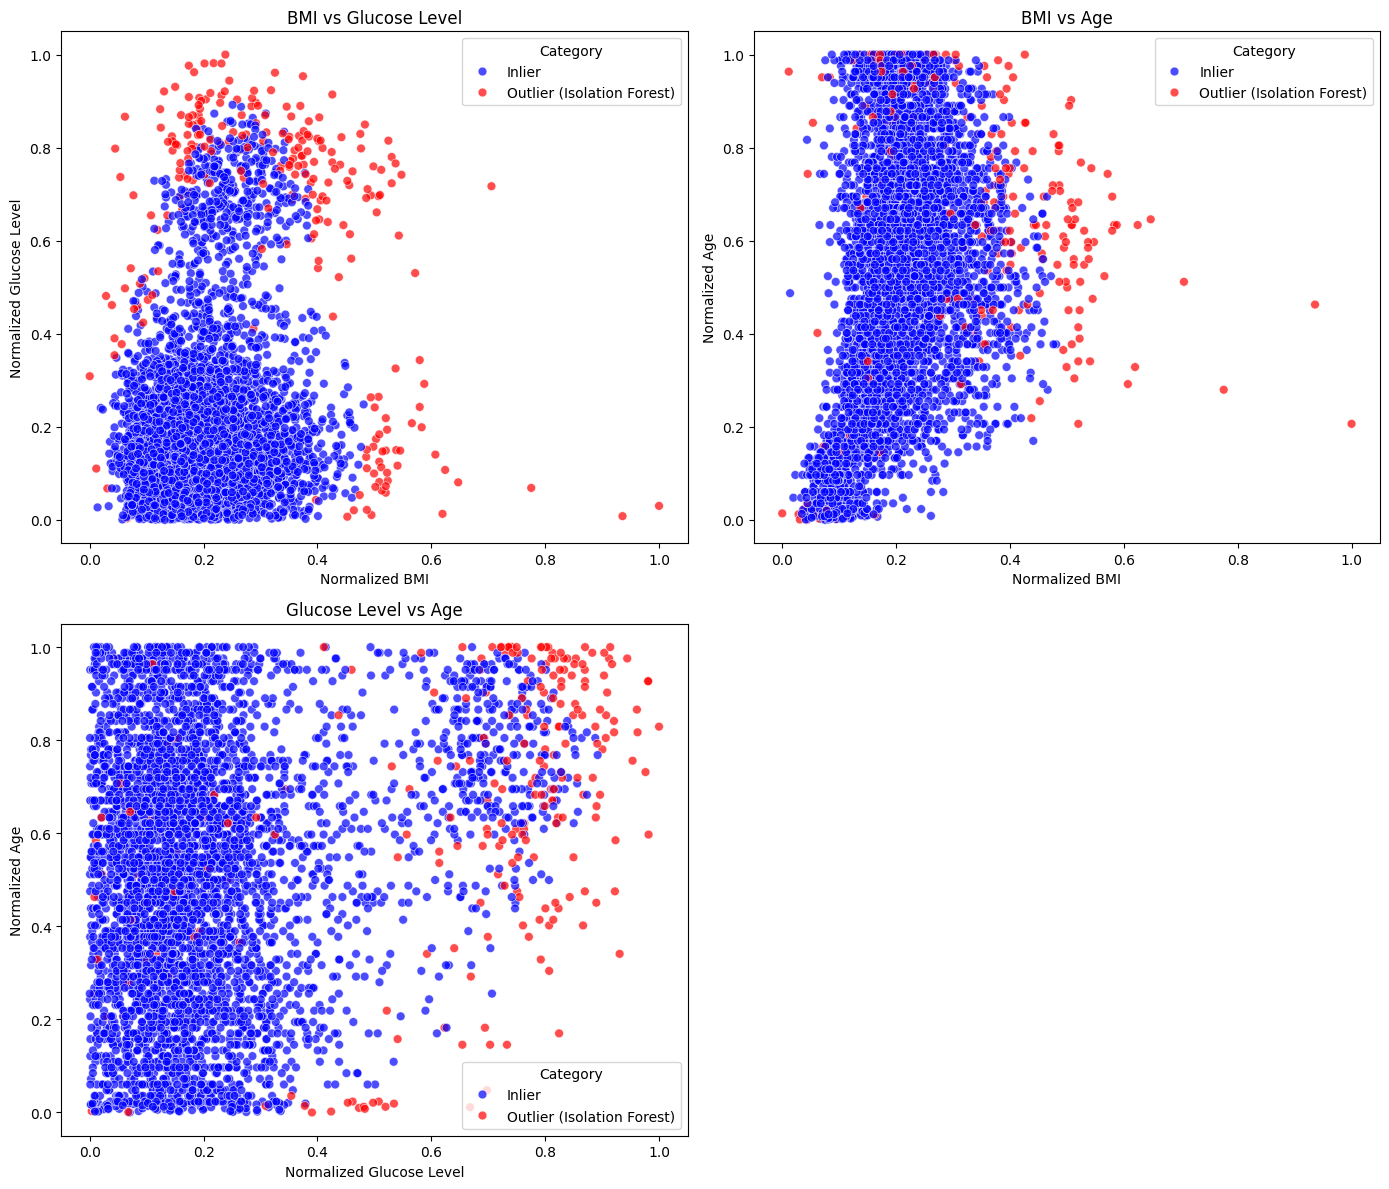

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# --- Load the dataset ---
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

# --- Numerical columns of interest ---
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

# --- PREPROCESSING STEP: Clean the data ---
print("🔹 Starting preprocessing...")

# 1. Remove duplicate rows
initial_rows = len(df)
df.drop_duplicates(inplace=True)
duplicates_removed = initial_rows - len(df)
print(f"Duplicates removed: {duplicates_removed}")

# 2. Handle infinite values (replace with NaN)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Remove rows with missing (NaN) values
rows_before_na_drop = len(df)
df.dropna(subset=numerical_cols, inplace=True)
na_removed = rows_before_na_drop - len(df)
print(f"Rows with missing data removed: {na_removed}")

# --- NORMALIZATION STEP ---
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# --- Isolation Forest for Outlier Detection ---
model = IsolationForest(random_state=42, contamination=0.05)
model.fit(df_scaled[numerical_cols])

# Predict anomalies (-1 = outlier, 1 = inlier)
df_scaled['is_outlier_if'] = np.where(model.predict(df_scaled[numerical_cols]) == -1,
                                      'Outlier (Isolation Forest)',
                                      'Inlier')

# --- SCATTER PLOTS (2x2 Grid) ---
plt.figure(figsize=(14, 12))

# 1️⃣ BMI vs Glucose
plt.subplot(2, 2, 1)
sns.scatterplot(
    x='bmi', y='avg_glucose_level', hue='is_outlier_if',
    data=df_scaled, palette={'Inlier': 'blue', 'Outlier (Isolation Forest)': 'red'},
    s=40, alpha=0.7
)
plt.title('BMI vs Glucose Level')
plt.xlabel('Normalized BMI')
plt.ylabel('Normalized Glucose Level')
plt.legend(title='Category')

# 2️⃣ BMI vs Age
plt.subplot(2, 2, 2)
sns.scatterplot(
    x='bmi', y='age', hue='is_outlier_if',
    data=df_scaled, palette={'Inlier': 'blue', 'Outlier (Isolation Forest)': 'red'},
    s=40, alpha=0.7
)
plt.title('BMI vs Age')
plt.xlabel('Normalized BMI')
plt.ylabel('Normalized Age')
plt.legend(title='Category')

# 3️⃣ Glucose vs Age
plt.subplot(2, 2, 3)
sns.scatterplot(
    x='avg_glucose_level', y='age', hue='is_outlier_if',
    data=df_scaled, palette={'Inlier': 'blue', 'Outlier (Isolation Forest)': 'red'},
    s=40, alpha=0.7
)
plt.title('Glucose Level vs Age')
plt.xlabel('Normalized Glucose Level')
plt.ylabel('Normalized Age')
plt.legend(title='Category')

plt.tight_layout()
plt.show()


## ML Approach

### Linear Regression

Linear Regression residual outliers detected: 32


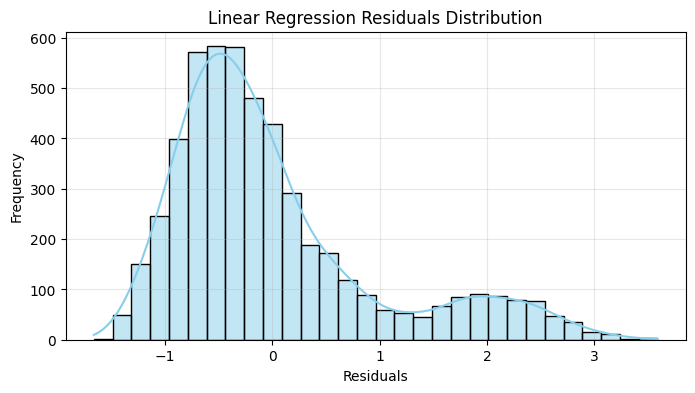

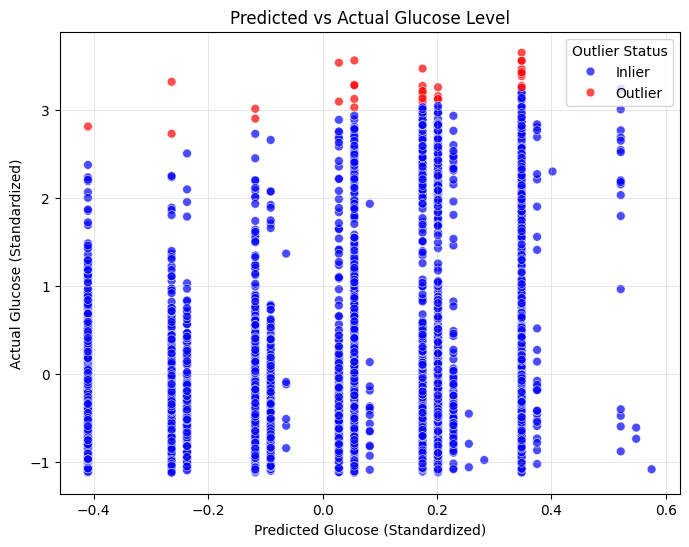

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# --- Load and Clean Data ---
df = pd.read_csv('data/processed_data.csv')
numerical_cols = ['age', 'bmi', 'avg_glucose_level']

# Remove duplicates and NaN
df.drop_duplicates(inplace=True)
df.dropna(subset=numerical_cols, inplace=True)

# --- Normalize the main numeric columns ---
scaler = StandardScaler()
df[['age_std', 'bmi_std', 'avg_glucose_level_std']] = scaler.fit_transform(df[numerical_cols])

# --- Create binned features (discretized versions of age and bmi) ---
# You can adjust number of bins to make them coarser/finer
df['age_bin'] = pd.cut(df['age_std'], bins=5, labels=False)
df['bmi_bin'] = pd.cut(df['bmi_std'], bins=5, labels=False)

# --- Linear Regression Outlier Detection ---
X_lin = df[['age_bin', 'bmi_bin']]
y_lin = df['avg_glucose_level_std']

lin_model = LinearRegression()
lin_model.fit(X_lin, y_lin)

# Predictions and residuals
pred_lin = lin_model.predict(X_lin)
resid_lin = y_lin - pred_lin

# Z-score normalization of residuals
z_lin = (resid_lin - resid_lin.mean()) / resid_lin.std()

# Outliers: |z| > 3
lin_outliers = np.abs(z_lin) > 3
df['lin_outlier'] = np.where(lin_outliers, 'Outlier', 'Inlier')

print(f"Linear Regression residual outliers detected: {lin_outliers.sum()}")

# --- Visualization 1: Residual Distribution ---
plt.figure(figsize=(8, 4))
sns.histplot(resid_lin, bins=30, kde=True, color='skyblue')
plt.title("Linear Regression Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

# --- Visualization 2: Scatter Plot of Predicted vs Actual ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pred_lin, y=y_lin, hue=df['lin_outlier'],
                palette={'Inlier': 'blue', 'Outlier': 'red'}, s=40, alpha=0.7)
plt.title("Predicted vs Actual Glucose Level")
plt.xlabel("Predicted Glucose (Standardized)")
plt.ylabel("Actual Glucose (Standardized)")
plt.legend(title="Outlier Status")
plt.grid(alpha=0.3)
plt.show()



### Piecewise (Segmented) Regression

Segmented Regression residual outliers detected: 33


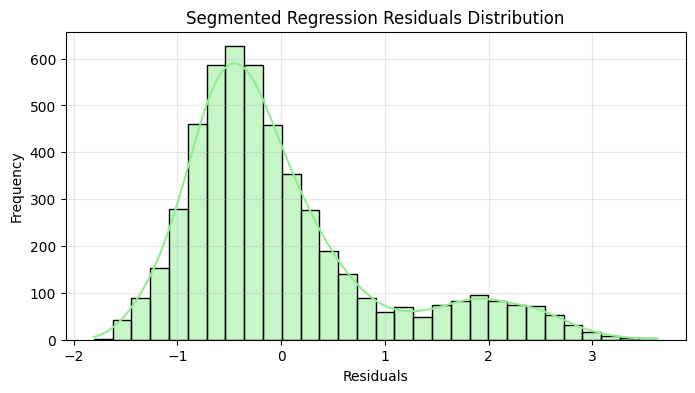

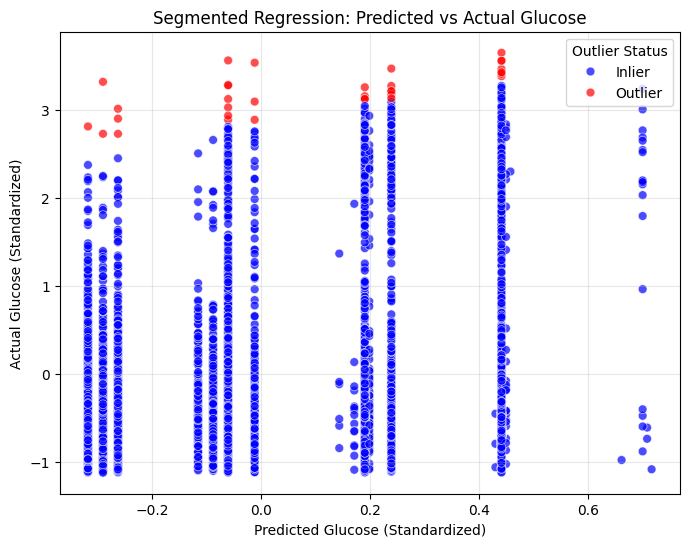

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# --- Load and Clean Data ---
df = pd.read_csv('data/processed_data.csv')
numerical_cols = ['age', 'bmi', 'avg_glucose_level']

# Remove duplicates and missing data
df.drop_duplicates(inplace=True)
df.dropna(subset=numerical_cols, inplace=True)

# --- Normalize numeric columns ---
scaler = StandardScaler()
df[['age_std', 'bmi_std', 'avg_glucose_level_std']] = scaler.fit_transform(df[numerical_cols])

# --- Discretize age and BMI for bin-level hinge regression ---
df['age_bin'] = pd.cut(df['age_std'], bins=5, labels=False)
df['bmi_bin'] = pd.cut(df['bmi_std'], bins=5, labels=False)

# --- Define hinge function (for segmented regression) ---
def hinge(x, knot):
    return np.maximum(0, x - knot)

# --- Determine knot positions (breakpoints) ---
age_knot = df['age_bin'].median()
bmi_knot = df['bmi_bin'].median()

# --- Create feature matrix for segmented regression ---
X_seg = pd.DataFrame({
    'age_bin': df['age_bin'],
    'bmi_bin': df['bmi_bin'],
    'age_hinge': hinge(df['age_bin'], age_knot),
    'bmi_hinge': hinge(df['bmi_bin'], bmi_knot)
})
y_seg = df['avg_glucose_level_std']

# --- Fit piecewise (segmented) regression ---
seg_model = LinearRegression()
seg_model.fit(X_seg, y_seg)

# Predictions and residuals
pred_seg = seg_model.predict(X_seg)
resid_seg = y_seg - pred_seg

# --- Outlier detection using z-score on residuals ---
z_seg = (resid_seg - resid_seg.mean()) / resid_seg.std()
seg_outliers = np.abs(z_seg) > 3
df['seg_outlier'] = np.where(seg_outliers, 'Outlier', 'Inlier')

print(f"Segmented Regression residual outliers detected: {seg_outliers.sum()}")

# --- Visualization 1: Residual Distribution ---
plt.figure(figsize=(8, 4))
sns.histplot(resid_seg, bins=30, kde=True, color='lightgreen')
plt.title("Segmented Regression Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

# --- Visualization 2: Predicted vs Actual Glucose ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pred_seg, y=y_seg, hue=df['seg_outlier'],
                palette={'Inlier': 'blue', 'Outlier': 'red'}, s=40, alpha=0.7)
plt.title("Segmented Regression: Predicted vs Actual Glucose")
plt.xlabel("Predicted Glucose (Standardized)")
plt.ylabel("Actual Glucose (Standardized)")
plt.legend(title="Outlier Status")
plt.grid(alpha=0.3)
plt.show()



### Clustering (DBSCAN)

DBSCAN noise points (outliers): 8


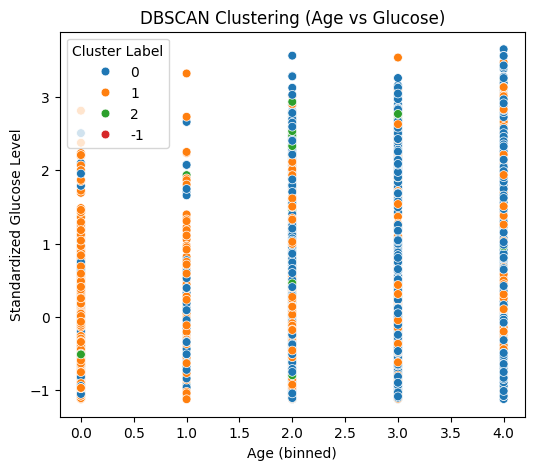

In [44]:
# === Clustering-Based Outlier Detection using DBSCAN ===

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select the relevant features
cluster_features = ['age_bin', 'bmi_bin', 'avg_glucose_level_std']

# Step 1: Scale the data (important for DBSCAN)
scaler = StandardScaler()
Xc_scaled = scaler.fit_transform(df[cluster_features])

# Step 2: Run DBSCAN clustering
# eps = neighborhood size (tune it for sensitivity)
# min_samples = minimum points per dense cluster
db = DBSCAN(eps=1.2, min_samples=10)
labels = db.fit_predict(Xc_scaled)

# Step 3: Assign cluster labels and mark noise points
df['dbscan_label'] = labels
db_outliers = labels == -1  # -1 means "noise" (outlier)

print("DBSCAN noise points (outliers):", db_outliers.sum())

# Step 4: Visualization (Age vs Glucose example)
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=df['age_bin'],
    y=df['avg_glucose_level_std'],
    hue=df['dbscan_label'].astype(str),
    palette='tab10',
    s=40
)
plt.title("DBSCAN Clustering (Age vs Glucose)")
plt.xlabel("Age (binned)")
plt.ylabel("Standardized Glucose Level")
plt.legend(title="Cluster Label")
plt.show()
